In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier  
from sklearn.feature_extraction.text import TfidfVectorizer


In [1]:

# ===============================
# ===============================
file_path = "Databds_CT1.csv"

try:
    df = pd.read_csv(file_path)
    print("✅ File CSV đã được đọc thành công. Dữ liệu đầu tiên:")
    print(df.head().to_markdown(index=False))
except FileNotFoundError:
    print(f"❌ Lỗi: Không tìm thấy file '{file_path}'.")
    df = pd.DataFrame()  # tạo DataFrame rỗng để tránh lỗi tiếp theo
except Exception as e:
    print(f"❌ Lỗi khi đọc file: {e}")
    df = pd.DataFrame()

# ===============================
# Kiểm tra df có dữ liệu không
# ===============================
if df.empty:
    print("❌ DataFrame rỗng. Không thể tiếp tục xử lý dữ liệu.")
else:
    #  Điền khuyết và chuẩn hóa cột địa lý 
    for col, default in [('ward', 'Chưa rõ Phường'),
                         ('district', 'Chưa rõ Quận/Huyện'),
                         ('province', 'Unknown')]:
        if col in df.columns:
            df[col] = df[col].fillna(default)
            df[col] = df[col].astype(str).str.strip().str.title()

    #  Chuẩn hóa 'property_type' 
    if 'property_type' in df.columns:
        df['property_type'] = df['property_type'].astype(str).str.strip().str.title()

    #  Điền khuyết và tạo cột is_company 
    if 'company_post' in df.columns:
        df['company_post'] = df['company_post'].fillna('Personal/Unknown')
        df['company_post'] = df['company_post'].astype(str).str.strip()
        df['is_company'] = df['company_post'].apply(lambda x: 0 if x in ['Personal/Unknown','Individual/Unknown'] else 1)

    #  4. Xử lý cột 'title' 
    if 'title' in df.columns:
        df['title'] = df['title'].fillna('')
        df['title_length'] = df['title'].apply(len)
        df['is_hot_listing'] = df['title'].str.contains('HOT|Giá Tốt|Cần Bán Gấp', case=False, na=False).astype(int)

    #  5. Xử lý cột 'description' 
    if 'description' in df.columns:
        df['description'] = df['description'].fillna('')
        df['content_length'] = df['description'].apply(len)
        df['has_legal_documents'] = df['description'].str.contains('sổ hồng|sổ đỏ|pháp lý rõ ràng', case=False, na=False).astype(int)

    #  6. TF-IDF cho 'title' 
    if 'title' in df.columns:
        tfidf_title = TfidfVectorizer(max_features=500)
        X_title = tfidf_title.fit_transform(df['title'])
        df_title_tfidf = pd.DataFrame(X_title.toarray(), columns=tfidf_title.get_feature_names_out())
        df = pd.concat([df.reset_index(drop=True), df_title_tfidf.reset_index(drop=True)], axis=1)
        df.drop('title', axis=1, inplace=True)

    #  7. TF-IDF cho 'description' 
    if 'description' in df.columns:
        tfidf_desc = TfidfVectorizer(max_features=1000)
        X_desc = tfidf_desc.fit_transform(df['description'])
        df_desc_tfidf = pd.DataFrame(X_desc.toarray(), columns=tfidf_desc.get_feature_names_out())
        df = pd.concat([df.reset_index(drop=True), df_desc_tfidf.reset_index(drop=True)], axis=1)
        df.drop('description', axis=1, inplace=True)

    #  8. Chuyển bool/int sang float 
    bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
    df[bool_cols] = df[bool_cols].astype(float)

    int_cols = df.select_dtypes(include=['int64', 'int32']).columns.tolist()
    df[int_cols] = df[int_cols].astype(float)

    #  9. Fillna cho object còn lại 
    object_cols = df.select_dtypes(include=['object']).columns.tolist()
    df[object_cols] = df[object_cols].fillna('')

    #  10. Chuẩn hóa tên cột 
    df.columns = [col.strip().lower() for col in df.columns]

    #  11. Xử lý thời gian từ actual_date 
    if 'actual_date' in df.columns:
        df['actual_date'] = pd.to_datetime(df['actual_date'], errors='coerce')
        df['actual_year'] = df['actual_date'].dt.year
        df['actual_month'] = df['actual_date'].dt.month
        df['actual_weekday'] = df['actual_date'].dt.dayofweek
        df.drop('actual_date', axis=1, inplace=True)

    #  12. Tạo tần suất district/ward 
    if 'district' in df.columns:
        district_counts = df['district'].value_counts(normalize=True)
        df['district_frequency'] = df['district'].map(district_counts)

    if 'ward' in df.columns:
        ward_counts = df['ward'].value_counts(normalize=True)
        df['ward_frequency'] = df['ward'].map(ward_counts)

    #  13. One-Hot Encoding cho property_type 
    if 'property_type' in df.columns:
        df_property_encoded = pd.get_dummies(df['property_type'], prefix='property_type')
        df = pd.concat([df, df_property_encoded], axis=1)
        df.drop('property_type', axis=1, inplace=True)

    print("✅ Pipeline xử lý dữ liệu hoàn tất. Dữ liệu hiện tại:")
    print(df.head().to_markdown(index=False))


✅ File CSV đã được đọc thành công. Dữ liệu đầu tiên:
|      price |   price_per_m2_million | actual_date             |     list_time | province       | district          | ward                               |   longitude |   latitude | property_type   |   apartment_type | project_name          |   area |   num_rooms |   num_toilets | company_post   |   contain_videos | is_pinned   |   num_images |   rating_score |   sold_status | title                                                                 | description                                                                          |
|-----------:|-----------------------:|:------------------------|--------------:|:---------------|:------------------|:-----------------------------------|------------:|-----------:|:----------------|-----------------:|:----------------------|-------:|------------:|--------------:|:---------------|-----------------:|:------------|-------------:|---------------:|--------------:|:--------------------------

In [3]:
object_cols = df.select_dtypes(include=['object']).columns.tolist()

if len(object_cols) == 0:
    print("✅ Không còn cột object nào trong df.")
else:
    print("Vẫn còn các cột object:", object_cols)

⚠️ Vẫn còn các cột object: ['province', 'district', 'ward', 'project_name', 'company_post']


In [45]:
 
import re
def clean_column_names(df):
    new_cols = []
    for col in df.columns:
        col_new = re.sub(r'[^a-z0-9_]+', '_', col.lower()).strip('_')
        new_cols.append(col_new)
    df.columns = new_cols
    return df

df = clean_column_names(df)


In [193]:
# Các cột cần giữ lại
columns_to_keep = [
    'price', 'price_per_m2_million', 'list_time', 'longitude', 'latitude', 'area',
    'num_rooms', 'num_toilets', 'contain_videos', 'is_pinned', 'num_images',
    'rating_score', 'sold_status', 'title_length', 'content_length', 'posting_year',
    'posting_month', 'posting_weekday', 'district_frequency', 'ward_frequency',
    'project_frequency', 'district'
]

# Chỉ giữ lại các cột có tồn tại trong DataFrame
columns_existing = [c for c in columns_to_keep if c in df.columns]

# Tạo df_valid để kiểm tra dữ liệu thô
df_valid = df[columns_existing].copy()

print("Các cột được giữ:", columns_existing)

# Các cột dùng cho mô hình outlier detection
model_cols = [
    'price', 'price_per_m2_million', 'area',
    'num_rooms', 'num_toilets', 'num_images',
    'rating_score', 'title_length', 'content_length',
    'district_frequency', 'ward_frequency', 'project_frequency'
]
cols_price = [
    'price', 'price_per_m2_million', 'area', 'num_rooms', 'num_toilets',
    'num_images', 'rating_score', 'contain_videos', 'is_pinned',
    'title_length', 'content_length', 'district_frequency', 'ward_frequency'
]
# Lọc theo các cột mô hình (và chỉ lấy những cột đang tồn tại)
model_cols_existing = [c for c in model_cols if c in df.columns]

df_model = df[model_cols_existing].copy()

# Thay NaN bằng 0
df_model = df_model.fillna(0)
df_price = df[cols_price].copy()
df_price = df_price.fillna(0)
print("Các cột mô hình:", model_cols_existing)


Các cột được giữ: ['price', 'price_per_m2_million', 'list_time', 'longitude', 'latitude', 'area', 'num_rooms', 'num_toilets', 'contain_videos', 'is_pinned', 'num_images', 'rating_score', 'sold_status', 'title_length', 'content_length', 'district_frequency', 'ward_frequency', 'district']
Các cột mô hình: ['price', 'price_per_m2_million', 'area', 'num_rooms', 'num_toilets', 'num_images', 'rating_score', 'title_length', 'content_length', 'district_frequency', 'ward_frequency']


In [49]:
if "district" in df.columns and "price" in df.columns:
    district_price_mean = df.groupby("district")["price"].mean()
    df_valid["price_by_district"] = df["district"].map(district_price_mean)

if "district" in df.columns and "price_per_m2_million" in df.columns:
    district_price_m2_mean = df.groupby("district")["price_per_m2_million"].mean()
    df_valid["price_per_m2_by_district"] = df["district"].map(district_price_m2_mean)

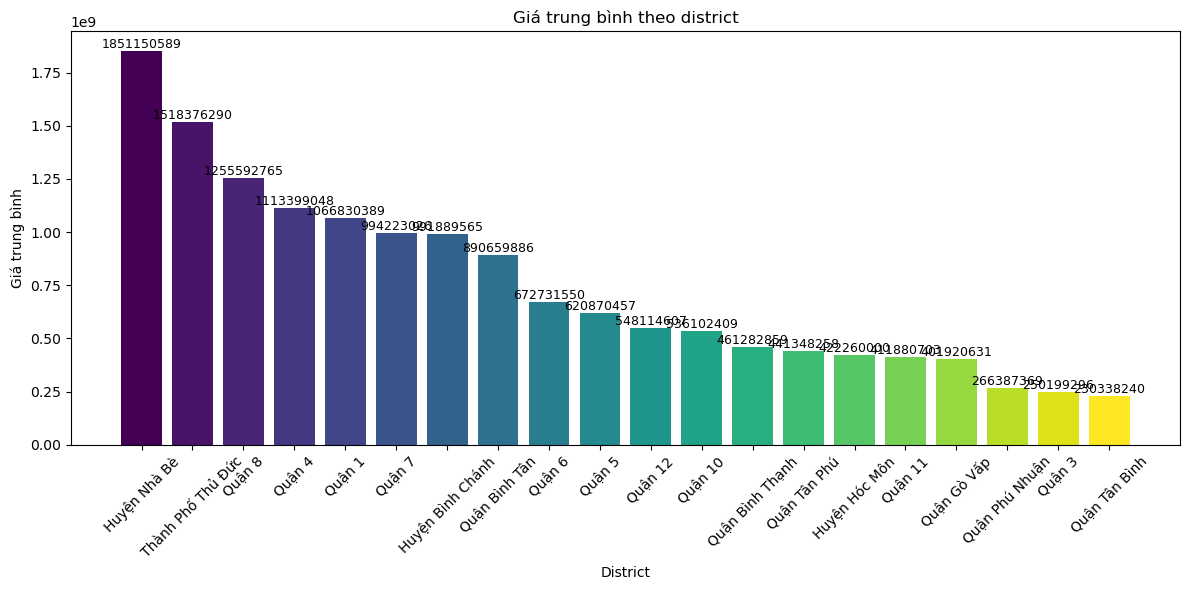

In [55]:
if 'price_by_district' in df_valid.columns:
    district_price = (
        df_valid[['district', 'price_by_district']]
        .drop_duplicates()
        .sort_values('price_by_district', ascending=False)
    )

    plt.figure(figsize=(12,6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(district_price)))

    bars = plt.bar(district_price['district'], district_price['price_by_district'],
                   color=colors)

    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h, 
                 f'{h:.0f}', ha='center', va='bottom', fontsize=9)

    plt.xticks(rotation=45)
    plt.title("Giá trung bình theo district")
    plt.ylabel("Giá trung bình")
    plt.xlabel("District")
    plt.tight_layout()
    plt.show()


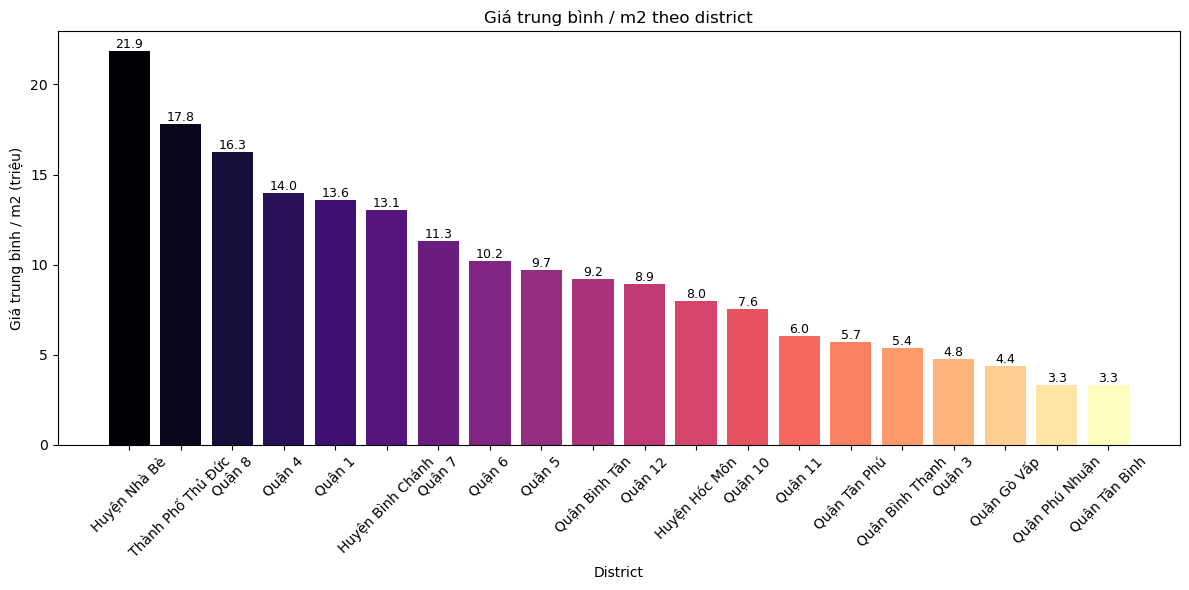

In [53]:
if 'price_per_m2_by_district' in df_valid.columns:
    district_price_m2 = (
        df_valid[['district', 'price_per_m2_by_district']]
        .drop_duplicates()
        .sort_values('price_per_m2_by_district', ascending=False)
    )

    plt.figure(figsize=(12,6))
    colors = plt.cm.magma(np.linspace(0, 1, len(district_price_m2)))

    bars = plt.bar(district_price_m2['district'], district_price_m2['price_per_m2_by_district'],
                   color=colors)

    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h, 
                 f'{h:.1f}', ha='center', va='bottom', fontsize=9)

    plt.xticks(rotation=45)
    plt.title("Giá trung bình / m2 theo district")
    plt.ylabel("Giá trung bình / m2 (triệu)")
    plt.xlabel("District")
    plt.tight_layout()
    plt.show()

In [59]:
df_valid = df_valid.dropna(subset=['sold_status'])

X = df_valid.drop('sold_status', axis=1)
y = df_valid['sold_status'].astype(int)


In [ ]:
Mô hình ML/Clustering

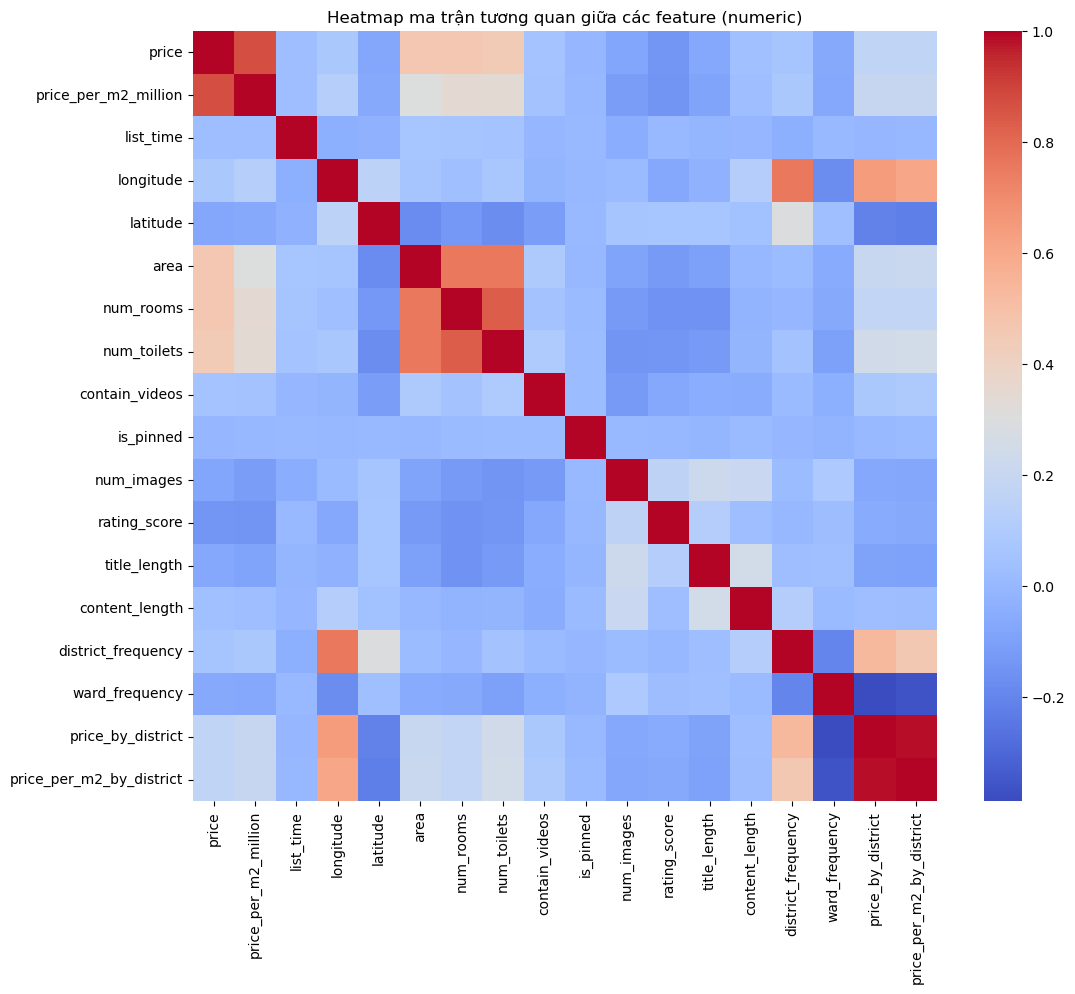

In [71]:
X_num = X.select_dtypes(include=['int', 'float'])
plt.figure(figsize=(12,10))
corr = X_num.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Heatmap ma trận tương quan giữa các feature (numeric)")
plt.show()


In [ ]:
#phát hiện giá bất thường

In [145]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_model)

In [147]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=300,
    contamination=0.03,       
    random_state=42
)

df['outlier_score'] = iso.fit_predict(X)
df['anomaly'] = df['outlier_score'].apply(lambda x: 'Outlier' if x == -1 else 'Normal')


In [149]:
df['anomaly'].value_counts()


anomaly
Normal     9652
Outlier     299
Name: count, dtype: int64

In [151]:
df_out = df[df['anomaly'] == 'Outlier']
df_out.head(20)


,price,price_per_m2_million,list_time,province,district,ward,longitude,latitude,apartment_type,project_name,...,,,actual_year,actual_month,actual_weekday,district_frequency,ward_frequency,property_type_c_n_h_chung_c,outlier_score,anomaly
25,5.900000e+09,86.764710,1.758035e+12,Tp Hồ Chí Minh,Thành Phố Thủ Đức,Phường An Phú (Quận 2 Cũ),106.753270,10.791790,1.0,Căn hộ D’Lusso,...,0.0,0.0,2025,9,1,0.171641,0.026530,True,-1,Outlier
41,5.350000e+09,97.272730,1.758035e+12,Tp Hồ Chí Minh,Thành Phố Thủ Đức,Phường Thảo Điền (Quận 2 Cũ),106.739990,10.801340,1.0,Masteri Thảo Điền,...,0.0,0.0,2025,9,1,0.171641,0.015275,True,-1,Outlier
51,9.000000e+06,0.225000,1.758035e+12,Tp Hồ Chí Minh,Quận Bình Thạnh,Phường 13,106.698944,10.818509,2.0,,...,0.0,0.0,2025,9,1,0.102904,0.041403,True,-1,Outlier
144,9.000000e+09,120.000000,1.758032e+12,Tp Hồ Chí Minh,Thành Phố Thủ Đức,Phường An Phú (Quận 2 Cũ),106.745960,10.802470,1.0,Lumière Riverside,...,0.0,0.0,2025,9,1,0.171641,0.026530,True,-1,Outlier
170,1.050000e+10,122.093025,1.758032e+12,Tp Hồ Chí Minh,Quận 10,Phường 12,106.678890,10.776200,1.0,Hà Đô Centrosa Garden,...,0.0,0.0,2025,9,1,0.046729,0.035775,True,-1,Outlier
192,1.500000e+10,113.636360,1.758031e+12,Tp Hồ Chí Minh,Quận Gò Vấp,Phường 16,106.664734,10.842343,2.0,,...,0.0,0.0,2025,9,1,0.057180,0.008843,True,-1,Outlier
205,1.300000e+07,0.094891,1.758031e+12,Tp Hồ Chí Minh,Quận 6,Phường 11,106.635200,10.747500,1.0,,...,0.0,0.0,2025,9,1,0.024420,0.024018,True,-1,Outlier
234,2.080000e+10,94.545456,1.758030e+12,Tp Hồ Chí Minh,Quận Bình Tân,Phường Bình Hưng Hoà B,106.599700,10.818957,2.0,,...,0.0,0.0,2025,9,1,0.037886,0.002010,True,-1,Outlier
260,1.600000e+07,0.114286,1.758030e+12,Tp Hồ Chí Minh,Quận 6,Phường 11,106.626330,10.745780,1.0,An Phú Apartment,...,0.0,0.0,2025,9,1,0.024420,0.024018,True,-1,Outlier
265,8.700000e+09,170.588240,1.758029e+12,Tp Hồ Chí Minh,Quận 1,Phường Đa Kao,106.699600,10.788530,1.0,The MarQ,...,0.0,0.0,2025,9,1,0.043915,0.007637,True,-1,Outlier


In [ ]:
df['price'] = df['price'].astype('int64')


In [215]:
# Hàm xác định lý do bất thường
def reason(row):
    reasons = []

    if row['price'] < df['price'].quantile(0.05):
        reasons.append("Giá quá thấp")
    if row['price'] > df['price'].quantile(0.95):
        reasons.append("Giá quá cao")

    if row['area'] < df['area'].quantile(0.05) and row['price'] > df['price'].quantile(0.80):
        reasons.append("Diện tích nhỏ nhưng giá cao")

    if row['content_length'] < 80 and row['price'] > df['price'].quantile(0.75):
        reasons.append("Nội dung ngắn nhưng giá cao")

    if row['num_images'] <= 1 and row['price'] > df['price'].quantile(0.70):
        reasons.append("Ít hình ảnh nhưng giá cao")

    return ", ".join(reasons) if reasons else "Không rõ"

# Lọc Outlier
df_out = df[df['anomaly'] == 'Outlier'].copy()

# Gán lý do bất thường
df_out.loc[:, 'reason'] = df_out.apply(reason, axis=1)

# Chỉ hiển thị những cột có thật trong df_out
columns_to_show = ['price', 'area', 'num_images', 'content_length', 'district', 'ward', 'project_name', 'reason']
columns_existing = [c for c in columns_to_show if c in df_out.columns]

# Hiển thị bảng
df_out[columns_existing].head(10)


,price,area,num_images,content_length,district,ward,project_name,reason
25,5900000000,68,8,285,Thành Phố Thủ Đức,Phường An Phú (Quận 2 Cũ),Căn hộ D’Lusso,Giá quá cao
41,5350000000,55,5,52,Thành Phố Thủ Đức,Phường Thảo Điền (Quận 2 Cũ),Masteri Thảo Điền,"Giá quá cao, Nội dung ngắn nhưng giá cao"
51,9000000,40,3,428,Quận Bình Thạnh,Phường 13,,Không rõ
144,9000000000,75,12,553,Thành Phố Thủ Đức,Phường An Phú (Quận 2 Cũ),Lumière Riverside,Giá quá cao
170,10500000000,86,5,"1,189",Quận 10,Phường 12,Hà Đô Centrosa Garden,Giá quá cao
192,15000000000,132,6,854,Quận Gò Vấp,Phường 16,,Giá quá cao
205,13000000,137,5,44,Quận 6,Phường 11,,Không rõ
234,20800000000,220,8,500,Quận Bình Tân,Phường Bình Hưng Hoà B,,Giá quá cao
260,16000000,140,5,51,Quận 6,Phường 11,An Phú Apartment,Nội dung ngắn nhưng giá cao
265,8700000000,51,3,"1,005",Quận 1,Phường Đa Kao,The MarQ,Giá quá cao


In [ ]:
#Phân tích yếu tố tác động đến giá 

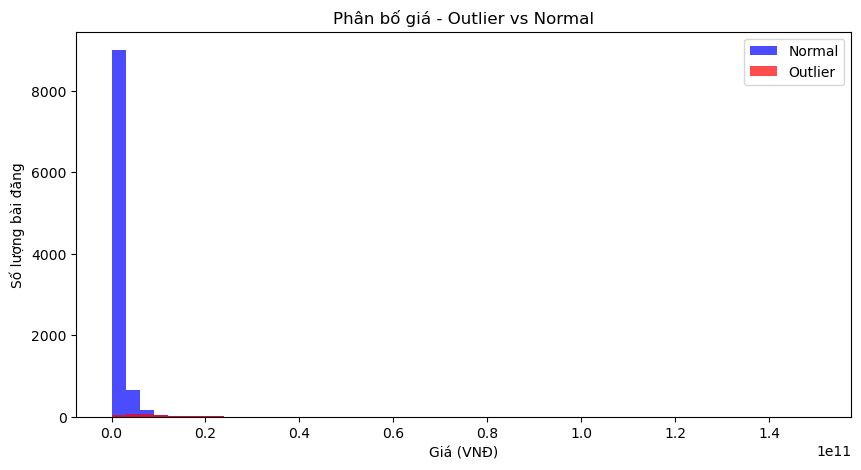

In [191]:
plt.figure(figsize=(10,5))
plt.hist(df['price'], bins=50, alpha=0.7, color='blue', label='Normal')
plt.hist(df_out['price'], bins=50, alpha=0.7, color='red', label='Outlier')
plt.xlabel("Giá (VNĐ)")
plt.ylabel("Số lượng bài đăng")
plt.title("Phân bố giá - Outlier vs Normal")
plt.legend()
plt.show()


In [195]:
corr_matrix = df_price.corr()


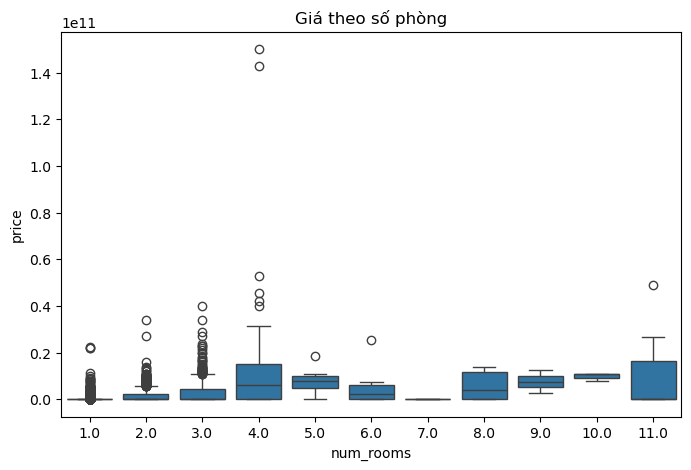

In [197]:
plt.figure(figsize=(8,5))
sns.boxplot(x='num_rooms', y='price', data=df_price)
plt.title("Giá theo số phòng")
plt.show()


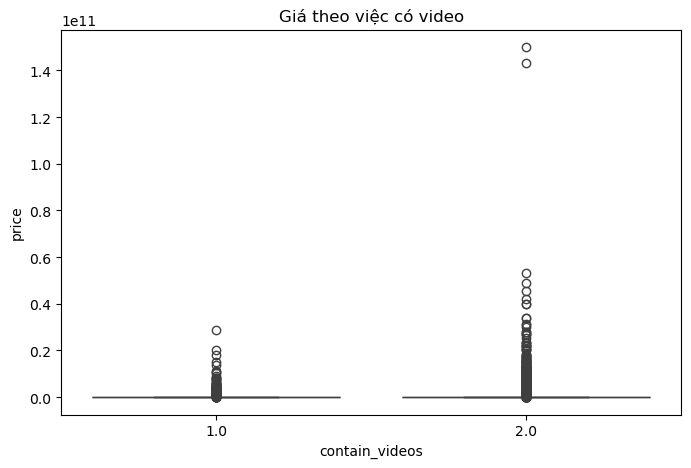

In [199]:
plt.figure(figsize=(8,5))
sns.boxplot(x='contain_videos', y='price', data=df_price)
plt.title("Giá theo việc có video")
plt.show()


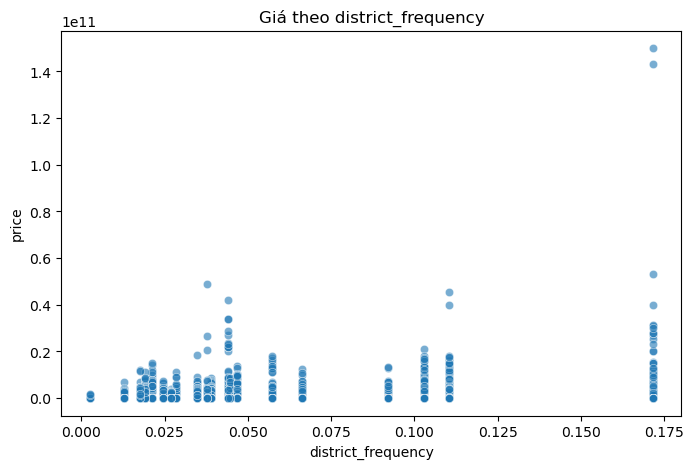

In [201]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='district_frequency', y='price', data=df_price, alpha=0.6)
plt.title("Giá theo district_frequency")
plt.show()


               feature  importance
0                 area           0
10      ward_frequency           0
2          num_toilets           0
8       content_length           0
7         title_length           0
1            num_rooms           0
9   district_frequency           0
3           num_images           0
4         rating_score           0
5       contain_videos           0
6            is_pinned           0


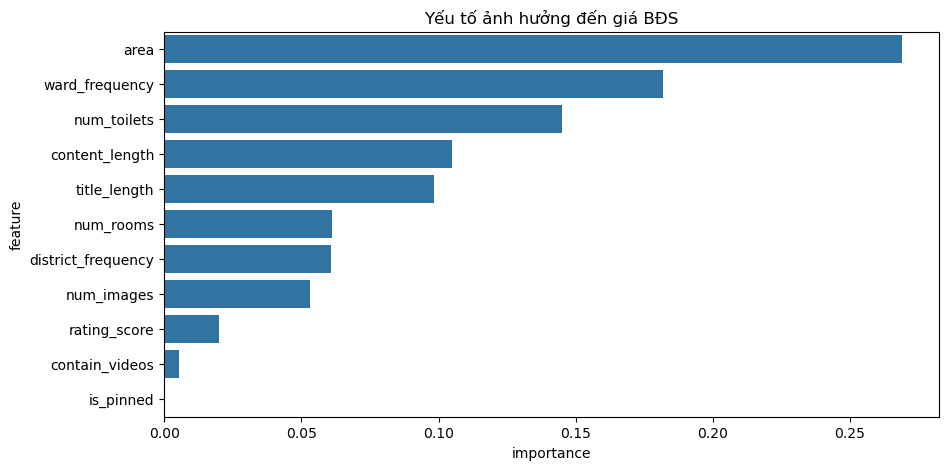

In [203]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

# X, y
X = df_price.drop(['price','price_per_m2_million'], axis=1)
y = df_price['price']

X['contain_videos'] = X['contain_videos'].astype(int)
X['is_pinned'] = X['is_pinned'].astype(int)

# Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X, y)

# Feature importance
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}).sort_values(by='importance', ascending=False)
print(feat_imp)

plt.figure(figsize=(10,5))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title("Yếu tố ảnh hưởng đến giá BĐS")
plt.show()
